Date: 2016-08-23

The goal of this notebook is to:
-  work out code to convert the existing Matlab data structures into pandas DataFrames.
-  make the data structures more 'flat' (*denormalize* in database terms) so that they're more easily readable

This first cell converts the *tasks* data to a single pandas DataFrame.

In [41]:
%matplotlib inline
%reload_ext autoreload
%autoreload 3
import os
import sys
import collections
import scipy.io
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd

sys.path.append('../src/')
import data_filter as df

# Setup
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

# Get all epochs
tasks = [(df.get_data_structure(animals[animal], day, 'task', 'task'), animal)
         for animal in animals
         for day in days]
epochs = [(epoch, animal) for day, animal in tasks for epoch in day] # flatten

# Convert into pandas dataframes
ndata = [{name: epoch[0][name][0][0][0]
          for name in epoch[0].dtype.names
          if name not in 'linearcoord'}
         for epoch in epochs]
df1 = pd.DataFrame(ndata)
# print(df1)

day_epoch_ind = [{'animal': day[1], 'day': day_ind + 1, 'epoch_ind': epoch_ind + 1}
                 for day_ind, day in enumerate(tasks)
                 for epoch_ind, epoch in enumerate(day[0])]

df2 = pd.DataFrame(day_epoch_ind)
# print(df2)

epochs_df = (pd
             .concat([df2, df1], axis=1, join_axes=[df1.index])
             .set_index(['animal', 'day', 'epoch_ind'])
             .assign(environment=lambda x: pd.Categorical(x['environment']))
             .assign(type=lambda x: pd.Categorical(x['type']))
            )

print(epochs_df.info())
print('\n')
print(epochs_df)
print('\n')

# Check accessing by Multi-dimensional index (animal HPa, days 6 and 8)
print(epochs_df.loc[(['HPa'], [6,8]), :])
print('\n')

print(epochs_df
      .loc[(['HPa'], [6,8]), :]
      .loc[epochs_df.environment == 'wtr1'])
print('\n')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 42 entries, (HPa, 1, 1) to (HPa, 8, 5)
Data columns (total 2 columns):
environment    33 non-null category
type           42 non-null category
dtypes: category(2)
memory usage: 484.0+ bytes
None


                     environment   type
animal day epoch_ind                   
HPa    1   1            presleep  sleep
           2                 lin    run
           3                 NaN   rest
           4                wtr1    run
           5                 NaN   rest
           6                wtr1    run
           7           postsleep  sleep
       2   1            presleep  sleep
           2                wtr1    run
           3                 NaN   rest
           4                wtr1    run
           5           postsleep  sleep
       3   1            presleep  sleep
           2                wtr1    run
           3                 NaN   rest
           4                wtr1    run
           5           postsleep 

Now the same thing with the tetrode info. This is a little trickier, because there are tetrodes for each epoch. It might be better to have one for each day-epoch (a dictionary of data frames).

In [2]:
def get_tetrode_info(animal):
    '''Returns the Matlab tetrodeinfo file name assuming it is in the Raw Data directory.
    '''
    data_dir = '{working_dir}/Raw-Data'.format(working_dir=os.path.abspath(os.path.pardir))
    return '{data_dir}/{animal.directory}/{animal.short_name}tetinfo.mat'.format(
        data_dir=data_dir,
        animal=animal)

def convert_to_dict(struct_array):
    try:
        return {name: np.squeeze(struct_array[name][0,0][0]) for name in struct_array.dtype.names}
    except TypeError:
        return {}

tetrode_file_names = [(get_tetrode_info(animals[animal]), animal) for animal in animals]

tetrode_info = [(scipy.io.loadmat(file_name[0]), file_name[1]) for file_name in tetrode_file_names]
tetrode_info = [(convert_to_dict(tetrode[0]), animal, day_ind + 1, epoch_ind + 1, tetrode_ind + 1)
       for info, animal in tetrode_info
       for day_ind, day in enumerate(info['tetinfo'].T)
       for epoch_ind, epoch in enumerate(day[0].T)
       for tetrode_ind, tetrode in enumerate(epoch[0].T)]

tet_df = pd.DataFrame([info[0] for info in tetrode_info])
day_epoch_ind = [{'animal': info[1], 'day': info[2], 'epoch_ind': info[3], 'tetrode_number': info[4]} 
                 for info in tetrode_info]
day_epoch_df = pd.DataFrame(day_epoch_ind)

tetrode_df = (pd
              .concat([day_epoch_df, tet_df], axis=1, join_axes=[day_epoch_df.index])
              .set_index(['animal', 'day', 'epoch_ind', 'tetrode_number'])  # set multi-index to identify rows
              .assign(numcells=lambda x: x['numcells'].astype(int))  # convert numcells to integer type
              .assign(depth=lambda x: x['depth'].astype(int)) # convert depth to integer type
              .assign(area=lambda x: pd.Categorical(x['area']))  # convert numcells to integer type
             )

print(tetrode_df.info())
print('\n')

# Check accessing by Multi-dimensional index

# Get all electrodes from HPa, day 8, epoch 2,4
print(tetrode_df.loc[(['HPa'], [8], [2,4]), :]) 
print('\n')

# Now only electrodes with cells recorded on them
print(tetrode_df
      .loc[tetrode_df.numcells > 0]
      .loc[('HPa', 8, [2,4])])
print('\n')

print(tetrode_df
      .loc[tetrode_df.numcells > 0]
      .loc[('HPa', 8, [2,4])].index.values)

tetrode_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 840 entries, (HPa, 1, 1, 1) to (HPa, 8, 5, 20)
Data columns (total 4 columns):
area        840 non-null category
depth       840 non-null int64
descrip     462 non-null object
numcells    840 non-null int64
dtypes: category(1), int64(2), object(1)
memory usage: 27.1+ KB
None


                                     area  depth descrip  numcells
animal day epoch_ind tetrode_number                               
HPa    8   2         1                CA1    113  riptet        12
                     2                CA1    121     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    116  riptet        15
                     5                CA1    116  riptet         0
                     6                CA1    110  riptet         0
                     7                CA1    114  riptet         0
                     8               iCA1    114  riptet         0
  

area  depth descrip  numcells
animal day epoch_ind tetrode_number                              
HPa    1   1         1               CA1    114  riptet         7
                     2               CA1    124     NaN         0
                     3               CA1     90  CA1Ref         0
                     4               CA1    117  riptet        13
                     5               CA1    119  riptet         1

Now let's try organizing tetrodes by a dictionary mapping (animal, day, epoch_ind) -> tetrode datatframe. If several dataframes are selected, they can be concatenated. This might be easier than trying to use the epochs dataframe.

In [3]:
tetrode_data = [(scipy.io.loadmat(file_name[0]), file_name[1]) for file_name in tetrode_file_names]

def convert_tetrode_epoch_to_dataframe(tetrodes_in_epoch, animal, day, epoch_ind):
    '''
    Given an epoch data structure, return a cleaned up DataFrame
    '''
    tetrode_dict_list = [convert_to_dict(tetrode) for tetrode in tetrodes_in_epoch[0][0]]
    return (pd.DataFrame(tetrode_dict_list)
              .assign(numcells=lambda x: x['numcells'].astype(int))  # convert numcells to integer type
              .assign(depth=lambda x: x['depth'].astype(int)) # convert depth to integer type
              .assign(area=lambda x: pd.Categorical(x['area']))  # convert numcells to integer type
              .assign(animal=lambda x: animal)
              .assign(day=lambda x: day)
              .assign(epoch_ind=lambda x: epoch_ind)
              .assign(tetrode_number=lambda x: x.index + 1)
              .set_index(['animal', 'day', 'epoch_ind', 'tetrode_number'])  # set index to identify rows
            )

# Make a dictionary with (animal, day, epoch_ind) as the keys
tetrode_info2 = {(animal, day_ind + 1, epoch_ind + 1): 
                  convert_tetrode_epoch_to_dataframe(epoch, animal, day_ind + 1, epoch_ind + 1)
                   for info, animal in tetrode_data
                   for day_ind, day in enumerate(info['tetinfo'].T)
                   for epoch_ind, epoch in enumerate(day[0].T)}

Get one dataframe based on a particular animal, day, epoch

In [4]:
epoch_keys = list(tetrode_info2.keys())
print(epoch_keys[0])
tetrode_info2[epoch_keys[0]]

('HPa', 5, 1)


area  depth descrip  numcells
animal day epoch_ind tetrode_number                               
HPa    5   1         1                CA1    114  riptet         9
                     2                CA1    121     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    117  riptet         9
                     5                CA1    117  riptet         2
                     6                CA1    110  riptet         0
                     7                CA1    114  riptet         0
                     8               iCA1    114  riptet         1
                     9               iCA1    101  riptet         1
                     10              iCA1     98     NaN         0
                     11              iCA1    108  riptet         0
                     12              iCA1    116  riptet         4
                     13              iCA1    120     NaN         0
                     14              iCA1    105  riptet         1
                     15               PFC    120     NaN         0
                     16               PFC    123     NaN         0
                     17               PFC    123     NaN         3
                     18               PFC    112     NaN         2
                     19               PFC    130     NaN         0
                     20               PFC    109     NaN         0

Get two dataframes and concat based on keys

In [5]:
print(epoch_keys[:2])
pd.concat([tetrode_info2[key] for key in epoch_keys[:2]])

[('HPa', 5, 1), ('HPa', 6, 4)]


area  depth descrip  numcells
animal day epoch_ind tetrode_number                               
HPa    5   1         1                CA1    114  riptet         9
                     2                CA1    121     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    117  riptet         9
                     5                CA1    117  riptet         2
                     6                CA1    110  riptet         0
                     7                CA1    114  riptet         0
                     8               iCA1    114  riptet         1
                     9               iCA1    101  riptet         1
                     10              iCA1     98     NaN         0
                     11              iCA1    108  riptet         0
                     12              iCA1    116  riptet         4
                     13              iCA1    120     NaN         0
                     14              iCA1    105  riptet         1
                     15               PFC    120     NaN         0
                     16               PFC    123     NaN         0
                     17               PFC    123     NaN         3
                     18               PFC    112     NaN         2
                     19               PFC    130     NaN         0
                     20               PFC    109     NaN         0
       6   4         1                CA1    114  riptet         7
                     2                CA1    121     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    117  riptet         8
                     5                CA1    117  riptet         5
                     6                CA1    110  riptet         0
                     7                CA1    114  riptet         0
                     8               iCA1    114  riptet         0
                     9               iCA1    101  riptet         1
                     10              iCA1     98     NaN         1
                     11              iCA1    108  riptet         1
                     12              iCA1    116  riptet         1
                     13              iCA1    120     NaN         0
                     14              iCA1    105  riptet         1
                     15               PFC    120     NaN         0
                     16               PFC    123     NaN         0
                     17               PFC    123     NaN         1
                     18               PFC    112     NaN         1
                     19               PFC    130     NaN         0
                     20               PFC    109     NaN         0

Now use the epoch data structure to get only those epochs with the w-track task and get the corresponding electrodes

In [6]:
epoch_keys = list(epochs_df.loc[epochs_df.environment == 'wtr1'].index)
pd.concat([tetrode_info2[key] for key in epoch_keys])

area  depth descrip  numcells
animal day epoch_ind tetrode_number                               
HPa    1   4         1                CA1    114  riptet         7
                     2                CA1    124     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    117  riptet        13
                     5                CA1    119  riptet         0
                     6                CA1    110  riptet         0
                     7                CA1    111  riptet         0
                     8               iCA1    116  riptet         1
                     9               iCA1    100  riptet         1
                     10              iCA1     99     NaN         0
                     11              iCA1    110  riptet         0
                     12              iCA1    118  riptet         0
                     13              iCA1    120     NaN         0
                     14              iCA1    106  riptet         1
                     15               PFC     96     NaN         2
                     16               PFC     94     NaN         2
                     17               PFC     98     NaN         3
                     18               PFC     90     NaN         4
                     19               PFC    104     NaN         0
                     20               PFC    101     NaN         0
           6         1                CA1    114  riptet         7
                     2                CA1    124     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    117  riptet        13
                     5                CA1    119  riptet         0
                     6                CA1    110  riptet         1
                     7                CA1    111  riptet         0
                     8               iCA1    116  riptet         1
                     9               iCA1    100  riptet         1
                     10              iCA1     99     NaN         0
...                                   ...    ...     ...       ...
       7   2         11              iCA1    108  riptet         3
                     12              iCA1    116  riptet         6
                     13              iCA1    120     NaN         0
                     14              iCA1    105  riptet         7
                     15               PFC     99     NaN         3
                     16               PFC     96     NaN         1
                     17               PFC     96     NaN         2
                     18               PFC     96     NaN         3
                     19               PFC    130     NaN         0
                     20               PFC    109     NaN         0
       8   2         1                CA1    113  riptet        12
                     2                CA1    121     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    116  riptet        15
                     5                CA1    116  riptet         0
                     6                CA1    110  riptet         0
                     7                CA1    114  riptet         0
                     8               iCA1    114  riptet         0
                     9               iCA1    100  riptet         0
                     10              iCA1     96     NaN         0
                     11              iCA1    106  riptet         0
                     12              iCA1    114  riptet         3
                     13              iCA1    120     NaN         0
                     14              iCA1    105  riptet         6
                     15               PFC     93     NaN         0
                     16               PFC     90     NaN         0
                     17               PFC     90     NaN         6
                 

Now say we want only the epochs where the animal is running the w-track and electrodes with at least one cell recorded

In [7]:
epoch_keys = list(epochs_df.loc[epochs_df.environment == 'wtr1'].index)
tetrodes_by_epoch = pd.concat([tetrode_info2[key] for key in epoch_keys])
tetrodes_by_epoch.loc[tetrodes_by_epoch.numcells > 0]

area  depth descrip  numcells
animal day epoch_ind tetrode_number                               
HPa    1   4         1                CA1    114  riptet         7
                     4                CA1    117  riptet        13
                     8               iCA1    116  riptet         1
                     9               iCA1    100  riptet         1
                     14              iCA1    106  riptet         1
                     15               PFC     96     NaN         2
                     16               PFC     94     NaN         2
                     17               PFC     98     NaN         3
                     18               PFC     90     NaN         4
           6         1                CA1    114  riptet         7
                     4                CA1    117  riptet        13
                     6                CA1    110  riptet         1
                     8               iCA1    116  riptet         1
                     9               iCA1    100  riptet         1
                     14              iCA1    106  riptet         1
                     15               PFC     96     NaN         2
                     16               PFC     94     NaN         2
                     17               PFC     98     NaN         3
                     18               PFC     90     NaN         4
       2   2         1                CA1    114  riptet         6
                     4                CA1    117  riptet         6
                     7                CA1    113  riptet         1
                     8               iCA1    114  riptet         1
                     12              iCA1    116  riptet         2
                     14              iCA1    106  riptet         3
                     15               PFC    100     NaN         4
                     17               PFC    104     NaN         2
                     18               PFC     96     NaN         4
           4         1                CA1    114  riptet         6
                     4                CA1    117  riptet         6
...                                   ...    ...     ...       ...
       6   2         4                CA1    117  riptet         8
                     5                CA1    117  riptet         5
                     8               iCA1    114  riptet         1
                     9               iCA1    101  riptet         1
                     10              iCA1     98     NaN         1
                     11              iCA1    108  riptet         1
                     12              iCA1    116  riptet         1
                     14              iCA1    105  riptet         1
                     17               PFC    123     NaN         1
                     18               PFC    112     NaN         1
       7   2         1                CA1    114  riptet         7
                     2                CA1    121     NaN         1
                     4                CA1    117  riptet        10
                     5                CA1    117  riptet         6
                     6                CA1    110  riptet         1
                     8               iCA1    114  riptet         1
                     9               iCA1    101  riptet         3
                     10              iCA1     98     NaN         1
                     11              iCA1    108  riptet         3
                     12              iCA1    116  riptet         6
                     14              iCA1    105  riptet         7
                     15               PFC     99     NaN         3
                     16               PFC     96     NaN         1
                     17               PFC     96     NaN         2
                     18               PFC     96     NaN         3
       8   2         1                CA1    113  riptet        12
                     4                CA1    116  riptet        15
                 

('HPa', 8, 2, 17)
/Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/Raw-Data/HPa_direct/EEG/HPaeeg08-2-17.mat
('descript', 'fields', 'starttime', 'samprate', 'data', 'depth')


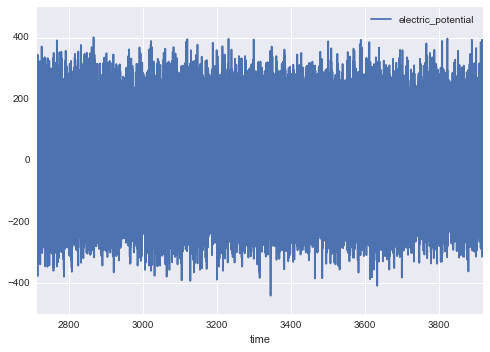

In [40]:
def get_df_index(data_frame):
    ''' Converts pandas dataframe to a list of tuples corresponding to
    the dataframe multi-index
    '''
    index = list(data_frame.index.get_values())
    return index


tetrode_index = get_df_index(tetrodes_by_epoch.loc[tetrodes_by_epoch.numcells > 0])

def get_LFP_file_name(index, animals):
    ''' Given an index tuple (animal, day, epoch, tetrode_number) and the animals dictionary
    return a file name for the tetrode file LFP
    '''
    data_dir = '{working_dir}/Raw-Data'.format(working_dir=os.path.abspath(os.path.pardir))
    return '{data_dir}/{animal.directory}/EEG/{animal.short_name}eeg{day:02d}-{epoch}-{tetrode_number:02d}.mat'.format(
        data_dir=data_dir,
        animal=animals[index[0]],
        day=index[1],
        epoch=index[2],
        tetrode_number=index[3]
    )


print(tetrode_index[-1])
print(get_LFP_file_name(tetrode_index[-1], animals))

def get_LFP_data(tetrode_index, animals):
    ''' Given a tetrode index tuple and the animals dictionary, 
    return the LFP data and start time
    '''
    lfp_file = scipy.io.loadmat(get_LFP_file_name(tetrode_index, animals))
    lfp_data = lfp_file['eeg'][0, -1][0, -1][0, -1]
    data_dict = {'time': _get_LFP_time(lfp_data['starttime'][0,0], lfp_data['data'][0,0].size, lfp_data['samprate'][0,0]),
                 'electric_potential': lfp_data['data'][0,0].squeeze()
                 }
    return pd.DataFrame(data_dict).set_index('time')

def _get_LFP_time(start_time, number_samples, sampling_rate):
    ''' Returns an array of time stamps
    '''
    end_time = start_time + (number_samples / sampling_rate)
    return np.round(np.arange(start_time, end_time, (1 / sampling_rate)), decimals=4)
    

lfp_file = scipy.io.loadmat(get_LFP_file_name(tetrode_index[-1], animals))
print(lfp_file['eeg'][0, -1][0, -1][0, -1].dtype.names)
lfp_data = get_LFP_data(tetrode_index[-1], animals)
lfp_data.plot()

Now let's do the same thing for the neuron info

In [9]:
def get_neuron_info(animal):
    '''Returns the Matlab tetrodeinfo file name assuming it is in the Raw Data directory.
    '''
    data_dir = '{working_dir}/Raw-Data'.format(working_dir=os.path.abspath(os.path.pardir))
    return '{data_dir}/{animal.directory}/{animal.short_name}cellinfo.mat'.format(
        data_dir=data_dir,
        animal=animal)

neuron_file_names = [(get_neuron_info(animals[animal]), animal) for animal in animals]
neuron_data = [(scipy.io.loadmat(file_name[0]), file_name[1]) for file_name in neuron_file_names]

def convert_neuron_epoch_to_dataframe(tetrodes_in_epoch, animal, day, epoch_ind):
    '''
    Given an neuron data structure, return a cleaned up DataFrame
    '''
    DROP_COLUMNS = ['ripmodtag', 'thetamodtag', 'runripmodtag', 'postsleepripmodtag',
                   'presleepripmodtag', 'runthetamodtag', 'ripmodtag2', 'runripmodtag2',
                   'postsleepripmodtag2', 'presleepripmodtag2', 'ripmodtype',
                   'runripmodtype', 'postsleepripmodtype', 'presleepripmodtype',
                   'FStag', 'ripmodtag3', 'runripmodtag3', 'ripmodtype3', 'runripmodtype3',
                   'tag', 'typetag', 'runripmodtype2', 'tag2', 'ripmodtype2', 'descrip']
    neuron_dict_list = [add_to_dict(convert_to_dict(neuron), tetrode_ind, neuron_ind)
                         for tetrode_ind, tetrode in enumerate(tetrodes_in_epoch[0][0])
                         for neuron_ind, neuron in enumerate(tetrode[0])
                        if neuron.size > 0
                       ]
    return (pd.DataFrame(neuron_dict_list)
              .drop(DROP_COLUMNS, 1, errors='ignore')
              .assign(animal=lambda x: animal)
              .assign(day=lambda x: day)
              .assign(epoch_ind=lambda x: epoch_ind)
              .set_index(['animal', 'day', 'epoch_ind', 'tetrode_number', 'neuron_number'])  # set index to identify rows
            )

def add_to_dict(dictionary, tetrode_ind, neuron_ind):
    dictionary['tetrode_number'] = tetrode_ind + 1
    dictionary['neuron_number'] = neuron_ind + 1
    return dictionary

# Make a dictionary with (animal, day, epoch_ind) as the keys
neuron_info = {(animal, day_ind + 1, epoch_ind + 1): 
                  convert_neuron_epoch_to_dataframe(epoch, animal, day_ind + 1, epoch_ind + 1)
                   for info, animal in neuron_data
                   for day_ind, day in enumerate(info['cellinfo'].T)
                   for epoch_ind, epoch in enumerate(day[0].T)
                }
epoch_keys = list(neuron_info.keys())
print(neuron_info[epoch_keys[1]].info())
neuron_info[epoch_keys[1]]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 36 entries, (HPa, 3, 3, 1, 1) to (HPa, 3, 3, 18, 4)
Data columns (total 6 columns):
area          26 non-null object
csi           26 non-null object
meanrate      26 non-null object
numspikes     26 non-null object
propbursts    26 non-null object
spikewidth    26 non-null object
dtypes: object(6)
memory usage: 2.0+ KB
None


area                    csi  \
animal day epoch_ind tetrode_number neuron_number                               
HPa    3   3         1              1              CA1    0.11153846153846154   
                                    2              CA1    0.09844559585492228   
                                    3              CA1     0.1476510067114094   
                                    4              CA1    0.06408483171968649   
                                    5              CA1    0.06976744186046512   
                                    6              CA1    0.14285714285714285   
                                    7              CA1   0.057692307692307696   
                                    8              CA1    0.06870229007633588   
                                    9              CA1    0.09090909090909091   
                     4              1              CA1     0.1008174386920981   
                                    2              CA1    0.08433734939759036   
                                    3              CA1    0.16783216783216784   
                                    4              CA1     0.1935483870967742   
                                    5              CA1    0.09615384615384616   
                                    6              CA1    0.11538461538461539   
                                    7              NaN                    NaN   
                     7              1              CA1    0.13548387096774195   
                                    2              CA1    0.10861423220973783   
                                    3              CA1    0.03773584905660377   
                                    4              CA1    0.12449799196787148   
                                    5              NaN                    NaN   
                                    6              NaN                    NaN   
                                    7              CA1    0.07920792079207921   
                                    8              CA1    0.17010309278350516   
                     8              1              NaN                    NaN   
                     9              1              NaN                    NaN   
                     14             1              NaN                    NaN   
                                    2              NaN                    NaN   
                     15             1              PFC   0.005668016194331984   
                                    2              PFC                      0   
                                    3              PFC    0.02765016902140938   
                                    4              PFC                      0   
                     18             1              NaN                    NaN   
                                    2              PFC  0.0036231884057971015   
                                    3              NaN                    NaN   
                                    4              NaN                    NaN   

                                                               meanrate  \
animal day epoch_ind tetrode_number neuron_number                         
HPa    3   3         1              1                0.4276315789473684   
                                    2               0.31743421052631576   
                                    3                0.2450657894736842   
                                    4                 3.567434210526316   
                                    5               0.28289473684210525   
                                    6              0.046052631578947366   
                                    7               0.17105263157894737   
                                    8                0.4309210526315789   
                                    9               0.16282894736842105   
                     4              1                 1.207236842105263   
                                    2                0.2730263157894737

In [10]:
epoch_keys = get_df_index(epochs_df.loc[epochs_df.environment == 'wtr1'])
pd.concat([neuron_info[key] for key in epoch_keys]).dropna()

area  \
animal day epoch_ind tetrode_number neuron_number         
HPa    1   4         1              1               CA1   
                                    2               CA1   
                                    3               CA1   
                                    4               CA1   
                                    5               CA1   
                                    6               CA1   
                     4              1               CA1   
                                    2               CA1   
                                    3               CA1   
                                    4               CA1   
                                    5               CA1   
                                    6               CA1   
                                    7               CA1   
                                    9               CA1   
                                    10              CA1   
                                    11              CA1   
                                    12              CA1   
                                    13              CA1   
                     8              1              iCA1   
                     9              1              iCA1   
                     14             1              iCA1   
                     15             1               PFC   
                                    2               PFC   
                     16             1               PFC   
                                    2               PFC   
                     17             2               PFC   
                     18             1               PFC   
                                    2               PFC   
                                    3               PFC   
           6         1              1               CA1   
...                                                 ...   
       7   2         18             2               PFC   
                                    3               PFC   
       8   2         1              1               CA1   
                                    2               CA1   
                                    3               CA1   
                                    4               CA1   
                                    5               CA1   
                                    6               CA1   
                                    7               CA1   
                     4              1               CA1   
                                    2               CA1   
                                    3               CA1   
                                    4               CA1   
                                    5               CA1   
                                    6               CA1   
                                    7               CA1   
                                    8               CA1   
                     12             1              iCA1   
                                    2              iCA1   
                                    3              iCA1   
                     14             1              iCA1   
                                    2              iCA1   
                                    3              iCA1   
                                    6              iCA1   
                     17             1               PFC   
                                    2               PFC   
                                    3               PFC   
                                    4               PFC   
                                    5               PFC   
                                    6               PFC   

                                                                     csi  \
animal day epoch_ind tetrode_number neuron_number                          
HPa    1   4         1              1                0.15163699023549684   
                                    2                   0.15368081676518   
                             

In [23]:
neuron_index = get_df_index(pd.concat([neuron_info[key] for key in epoch_keys]).dropna())
print(neuron_index[-1])


def get_neuron_data(neuron_index, animals):
    ''' Given a neuron index tuple and the animals dictionary, 
    return the spike times
    '''
    neuron_file = scipy.io.loadmat(df.get_data_filename(animals[neuron_index[0]], neuron_index[1], 'spikes'))
    return neuron_file['spikes'][0, -1][0, neuron_index[2] - 1][0, neuron_index[3] - 1][0, neuron_index[4] - 1][0]['data']

print(get_neuron_data(neuron_index[-1], animals)[0])


('HPa', 8, 2, 17, 6)
[[  2.71344770e+03   9.62000000e+01   1.05950000e+02 ...,   9.62162673e+01
    1.05660690e+02   6.61617632e-01]
 [  2.71362580e+03   9.62000000e+01   1.05300000e+02 ...,   9.61594889e+01
    1.05410010e+02   6.59681126e-01]
 [  2.71366690e+03   9.62000000e+01   1.05300000e+02 ...,   9.61530958e+01
    1.05405284e+02   6.60198741e-01]
 ..., 
 [  3.91980730e+03   1.02050000e+02   1.00750000e+02 ...,   1.02205782e+02
    1.00416081e+02  -2.65838534e-02]
 [  3.91983050e+03   1.01400000e+02   1.00100000e+02 ...,   1.01925888e+02
    1.00393648e+02  -4.35875789e-02]
 [  3.91988440e+03   1.01400000e+02   1.00100000e+02 ...,   1.01611592e+02
    1.00360565e+02  -6.16906623e-02]]
